# Toy MC for the ATLAS High Granularity Timing Detector

In [1]:
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import matplotlib.pyplot as plt
import time 
from array import array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

Welcome to JupyROOT 6.22/08


### Constants

In [2]:
nr_of_channels = int(3.6 * 1e6)
channels_per_module = int(15*30)
total_modules = int(nr_of_channels/channels_per_module)
global_counter = 0

### Noise Generator Class:
This class takes in the parameters threshold and channel count (proportional to the number of interactions mu per bunch crossing) and calculates the mean number of channels activated by noise by calculating the probability mass that a part of the Gaussian distribution will be above the set average, and multiplies it with the total number of channels. The class has a function generate, which calculates a variation of the mean number of noise activated channels by drawing from a Poisson dist. with mean as parameter, and calculates how many of them are triggered during the small time window of 3.125ns (true value of them!) by drawing from a uniform dist. (0,1) for each number of noise activated channel and seeing how many are under 0.125 (3.125/25 = 0.125). Finally, it estimates the number of triggered channels in the small window by determining the number of channels triggered in one ns and multiplying by 3.125ns. This way, we have a true number of noise activated channels in the small window, and one that is estimated.

try different big time windows , eg 4*3.125, lines 25-26. Change value of *big_window*

In [3]:
class noise_generator:
    def __init__(self, threshold, channel_count): 
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        """Why divide with 2?? Why do we need a avg. value?"""
        #integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg.
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)

    def generate(self):
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        # Large time window 25ns
        # Small time window 3.125ns
        prng = self._prng
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        
        narrow_exact = 0
        big_window = 4*3.125
        
        #narrow_exact = (np.random.rand(total) < 0.125).sum()  # 3.125/25 = 0.125
        #noise_per_time = (total - narrow_exact)/(25 - 3.125)
        
        narrow_exact = (np.random.rand(total) < 3.125/big_window).sum() # ex. 3.125/(3.125*4) big window of 4 times 3.125 
        noise_per_time = (total - narrow_exact)/(big_window - 3.125)
        
        estimate = 3.125 * noise_per_time
        return narrow_exact, estimate




 ### Signal Generator Class:
 This class takes the input parametes threshold and the real and guessed most probable peak voltage of the signal distribution (100mV when the sensors are new). It calculates the fraction of the Landau distribution that will be above the set threshold. It has a function generate, which takes in the paramter expected_count, that is, the estimated number of particles that will reach the detector (for mu=200 it is around 15k), then it determines a possible number of hits on the detector by drawing from a Poisson distribution around that parameter. Finally, for each calculated hit, it determines how many channels were triggered by signal from a particle by sampling a Landau distribution and checking how many of them are above the threshold. It returns the number of particles hitting the detector, and the number of signal-activated channels.

In [4]:
class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) #fraction of the function that is above threshold
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    

## Simulation function


In [5]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true[BC] = total_signal_est - total_actual_signal
        deviation_from_true[BC] = deviation_from_true[BC]/ total_actual_signal
    return result_true_signal_count, result_estimated_signal_count, deviation_from_true

### Function to find best threshold

In [6]:
def find_best_threshold (total_deviation):
    """Input parameter is a list of the deviation for each threshold, returns the best threshold with lowest deviation"""
    
    total_deviation = [round(num, 6) for num in total_deviation]

    best_array_indexes = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
    print("Size of array: %d" %len(best_array_indexes))
    best_thresholds_array = np.zeros(len(best_array_indexes))
    if len(best_array_indexes)==1:
         print("best threshold: %f" %(threshold_array[best_array_indexes[0]]))
         return threshold_array[best_array_indexes[0]]
    
    else: 
        for i in range (len(best_array_indexes)):
            best_thresholds_array[i] = threshold_array[best_array_indexes[i]]
        print (best_thresholds_array)
        return sum(best_thresholds_array)/len(best_thresholds_array)

### Parameters for the simulation

In [28]:
peak_mpv_voltage = 100 #mV, mpv: most probable value
guess_mpv_voltage = 100 #mV
mu = 100

"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
bunch_crossings = 1000
ratio_of_channels_to_sample = 0.5
print("Expected count: %f" %expected_count)

min_threshold = 15#mV
max_threshold = 35#mV
threshold_steps = 30

#Put same min and max, and step=1 to try only for a single mpv of peak voltage
min_mpv_peak = 10 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
mpv_peak_steps = 30
guess_mpv_voltage_bias = 1 #percentage of bias of guessed mpv voltage

Expected count: 7500.000000


## Computation

In [29]:
start_time = time.time()

mpv_peak_array = np.linspace(min_mpv_peak,max_mpv_peak,mpv_peak_steps)
threshold_array = np.linspace(min_threshold,max_threshold,threshold_steps)
best_threshold_array = np.zeros (len(mpv_peak_array))
min_deviation_array = np.zeros(len(mpv_peak_array))
mpv_and_deviation = np.zeros((len(threshold_array), len(mpv_peak_array)))

iteration_peak = 0

for peak_value_step in mpv_peak_array:
    print ("\n------------------------------------------------------------")
    print("Simulations for mpv peak voltage %dmV\n" %peak_value_step)

    iteration = 0
    total_deviation= np.zeros(len(threshold_array))
    mean_values = []
    mean_values_with_std = []
    std_values = []
    
    for threshold in threshold_array:
        true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_value_step, peak_value_step*guess_mpv_voltage_bias)
        """Get the total deviation from the total simulated signals vs the expected signals.
            Returns both the total deviation as a positive number"""
           
        true_signal_sum = true_signal.sum()
        if true_signal_sum == 0:
            deviation = 0
        deviation = abs( estimated_signal.sum() / true_signal_sum -1)
        total_deviation[iteration] = deviation
        #print("\nDeviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
        
        mean_values.append(abs(np.mean(dev_per_BC)))
        mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        print ("Mean dev for threshold %f: %f" %(threshold, mean_values[iteration]))
        std_values.append(np.std(dev_per_BC))
        print ("Std for threshold %f: %f" %(threshold, std_values[iteration]))
            
        mpv_and_deviation[iteration][iteration_peak] = np.mean(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        iteration = iteration+1
            
    best_threshold_array [iteration_peak] = find_best_threshold(mean_values)
    min_deviation_array [iteration_peak] = min(mean_values)
    print ("Best threshold for mpv peak voltage %dmV: %fmV" %(peak_value_step,best_threshold_array[iteration_peak]))
    print ("Minimum deviation for mpv peak voltage %d: %f" %(peak_value_step, min_deviation_array[iteration_peak]))
    print ("------------------------------------------------------------\n") 
    iteration_peak = iteration_peak+1
    
print("Computation done!\nCPU time: %s seconds" % (time.time() - start_time))



Simulations for mpv peak voltage 10mV


Mean dev for threshold 15.000000: 0.003574
Std for threshold 15.000000: 0.018702

Mean dev for threshold 15.689655: 0.003932
Std for threshold 15.689655: 0.018332

Mean dev for threshold 16.379310: 0.003799
Std for threshold 16.379310: 0.017282

Mean dev for threshold 17.068966: 0.004574
Std for threshold 17.068966: 0.017835

Mean dev for threshold 17.758621: 0.005709
Std for threshold 17.758621: 0.018703

Mean dev for threshold 18.448276: 0.006074
Std for threshold 18.448276: 0.018259

Mean dev for threshold 19.137931: 0.005050
Std for threshold 19.137931: 0.018544

Mean dev for threshold 19.827586: 0.007122
Std for threshold 19.827586: 0.019906

Mean dev for threshold 20.517241: 0.007114
Std for threshold 20.517241: 0.020073

Mean dev for threshold 21.206897: 0.006450
Std for threshold 21.206897: 0.020445

Mean dev for threshold 21.896552: 0.009206
Std for threshold 21.896552: 0.021655

Mean dev for threshold 22.586207: 0.007903
Std for thresh


Mean dev for threshold 17.068966: 0.001548
Std for threshold 17.068966: 0.006631

Mean dev for threshold 17.758621: 0.001567
Std for threshold 17.758621: 0.006890

Mean dev for threshold 18.448276: 0.001474
Std for threshold 18.448276: 0.007119

Mean dev for threshold 19.137931: 0.001880
Std for threshold 19.137931: 0.007292

Mean dev for threshold 19.827586: 0.001926
Std for threshold 19.827586: 0.007866

Mean dev for threshold 20.517241: 0.002426
Std for threshold 20.517241: 0.008264

Mean dev for threshold 21.206897: 0.002769
Std for threshold 21.206897: 0.008858

Mean dev for threshold 21.896552: 0.003193
Std for threshold 21.896552: 0.009271

Mean dev for threshold 22.586207: 0.003228
Std for threshold 22.586207: 0.009866

Mean dev for threshold 23.275862: 0.003869
Std for threshold 23.275862: 0.009861

Mean dev for threshold 23.965517: 0.004065
Std for threshold 23.965517: 0.010321

Mean dev for threshold 24.655172: 0.004493
Std for threshold 24.655172: 0.010560

Mean dev for th


Mean dev for threshold 19.137931: 0.000639
Std for threshold 19.137931: 0.003502

Mean dev for threshold 19.827586: 0.000435
Std for threshold 19.827586: 0.003475

Mean dev for threshold 20.517241: 0.000914
Std for threshold 20.517241: 0.003757

Mean dev for threshold 21.206897: 0.000719
Std for threshold 21.206897: 0.004014

Mean dev for threshold 21.896552: 0.001093
Std for threshold 21.896552: 0.004413

Mean dev for threshold 22.586207: 0.001191
Std for threshold 22.586207: 0.004706

Mean dev for threshold 23.275862: 0.001566
Std for threshold 23.275862: 0.004912

Mean dev for threshold 23.965517: 0.001571
Std for threshold 23.965517: 0.005213

Mean dev for threshold 24.655172: 0.001852
Std for threshold 24.655172: 0.005720

Mean dev for threshold 25.344828: 0.001759
Std for threshold 25.344828: 0.005865

Mean dev for threshold 26.034483: 0.002293
Std for threshold 26.034483: 0.005933

Mean dev for threshold 26.724138: 0.002539
Std for threshold 26.724138: 0.006595

Mean dev for th


Mean dev for threshold 21.206897: 0.000291
Std for threshold 21.206897: 0.002034

Mean dev for threshold 21.896552: 0.000524
Std for threshold 21.896552: 0.002104

Mean dev for threshold 22.586207: 0.000424
Std for threshold 22.586207: 0.002334

Mean dev for threshold 23.275862: 0.000362
Std for threshold 23.275862: 0.002520

Mean dev for threshold 23.965517: 0.000549
Std for threshold 23.965517: 0.002676

Mean dev for threshold 24.655172: 0.000650
Std for threshold 24.655172: 0.002919

Mean dev for threshold 25.344828: 0.000889
Std for threshold 25.344828: 0.003152

Mean dev for threshold 26.034483: 0.001028
Std for threshold 26.034483: 0.003444

Mean dev for threshold 26.724138: 0.001142
Std for threshold 26.724138: 0.003631

Mean dev for threshold 27.413793: 0.001058
Std for threshold 27.413793: 0.003843

Mean dev for threshold 28.103448: 0.001253
Std for threshold 28.103448: 0.003960

Mean dev for threshold 28.793103: 0.001356
Std for threshold 28.793103: 0.004269

Mean dev for th


Mean dev for threshold 23.965517: 0.000180
Std for threshold 23.965517: 0.001432

Mean dev for threshold 24.655172: 0.000255
Std for threshold 24.655172: 0.001548

Mean dev for threshold 25.344828: 0.000208
Std for threshold 25.344828: 0.001665

Mean dev for threshold 26.034483: 0.000322
Std for threshold 26.034483: 0.001853

Mean dev for threshold 26.724138: 0.000382
Std for threshold 26.724138: 0.001978

Mean dev for threshold 27.413793: 0.000455
Std for threshold 27.413793: 0.002139

Mean dev for threshold 28.103448: 0.000502
Std for threshold 28.103448: 0.002328

Mean dev for threshold 28.793103: 0.000471
Std for threshold 28.793103: 0.002481

Mean dev for threshold 29.482759: 0.000800
Std for threshold 29.482759: 0.002630

Mean dev for threshold 30.172414: 0.000906
Std for threshold 30.172414: 0.002701

Mean dev for threshold 30.862069: 0.000943
Std for threshold 30.862069: 0.002914

Mean dev for threshold 31.551724: 0.000779
Std for threshold 31.551724: 0.003119

Mean dev for th


Mean dev for threshold 26.034483: 0.000132
Std for threshold 26.034483: 0.001035

Mean dev for threshold 26.724138: 0.000106
Std for threshold 26.724138: 0.001143

Mean dev for threshold 27.413793: 0.000238
Std for threshold 27.413793: 0.001254

Mean dev for threshold 28.103448: 0.000280
Std for threshold 28.103448: 0.001341

Mean dev for threshold 28.793103: 0.000289
Std for threshold 28.793103: 0.001529

Mean dev for threshold 29.482759: 0.000321
Std for threshold 29.482759: 0.001550

Mean dev for threshold 30.172414: 0.000253
Std for threshold 30.172414: 0.001713

Mean dev for threshold 30.862069: 0.000407
Std for threshold 30.862069: 0.001794

Mean dev for threshold 31.551724: 0.000557
Std for threshold 31.551724: 0.001937

Mean dev for threshold 32.241379: 0.000528
Std for threshold 32.241379: 0.002027

Mean dev for threshold 32.931034: 0.000619
Std for threshold 32.931034: 0.002164

Mean dev for threshold 33.620690: 0.000709
Std for threshold 33.620690: 0.002296

Mean dev for th


Mean dev for threshold 28.103448: 0.000125
Std for threshold 28.103448: 0.000838

Mean dev for threshold 28.793103: 0.000077
Std for threshold 28.793103: 0.000890

Mean dev for threshold 29.482759: 0.000144
Std for threshold 29.482759: 0.000961

Mean dev for threshold 30.172414: 0.000121
Std for threshold 30.172414: 0.001050

Mean dev for threshold 30.862069: 0.000217
Std for threshold 30.862069: 0.001147

Mean dev for threshold 31.551724: 0.000171
Std for threshold 31.551724: 0.001196

Mean dev for threshold 32.241379: 0.000221
Std for threshold 32.241379: 0.001276

Mean dev for threshold 32.931034: 0.000277
Std for threshold 32.931034: 0.001447

Mean dev for threshold 33.620690: 0.000251
Std for threshold 33.620690: 0.001428

Mean dev for threshold 34.310345: 0.000288
Std for threshold 34.310345: 0.001608

Mean dev for threshold 35.000000: 0.000410
Std for threshold 35.000000: 0.001658
Size of array: 1
best threshold: 18.448276
Best threshold for mpv peak voltage 65mV: 18.448276mV
M


Mean dev for threshold 30.172414: 0.000028
Std for threshold 30.172414: 0.000663

Mean dev for threshold 30.862069: 0.000087
Std for threshold 30.862069: 0.000732

Mean dev for threshold 31.551724: 0.000137
Std for threshold 31.551724: 0.000766

Mean dev for threshold 32.241379: 0.000126
Std for threshold 32.241379: 0.000857

Mean dev for threshold 32.931034: 0.000171
Std for threshold 32.931034: 0.000886

Mean dev for threshold 33.620690: 0.000182
Std for threshold 33.620690: 0.000954

Mean dev for threshold 34.310345: 0.000151
Std for threshold 34.310345: 0.001015

Mean dev for threshold 35.000000: 0.000236
Std for threshold 35.000000: 0.001090
Size of array: 1
best threshold: 23.275862
Best threshold for mpv peak voltage 75mV: 23.275862mV
Minimum deviation for mpv peak voltage 75: 0.000001

Simulations for mpv peak voltage 78mV


Mean dev for threshold 15.000000: 0.000038
Std for threshold 15.000000: 0.005477

Mean dev for threshold 15.689655: 0.000287
Std for threshold 15.689655: 


Mean dev for threshold 32.241379: 0.000052
Std for threshold 32.241379: 0.000559

Mean dev for threshold 32.931034: 0.000077
Std for threshold 32.931034: 0.000589

Mean dev for threshold 33.620690: 0.000065
Std for threshold 33.620690: 0.000634

Mean dev for threshold 34.310345: 0.000115
Std for threshold 34.310345: 0.000682

Mean dev for threshold 35.000000: 0.000160
Std for threshold 35.000000: 0.000731
Size of array: 1
best threshold: 15.689655
Best threshold for mpv peak voltage 84mV: 15.689655mV
Minimum deviation for mpv peak voltage 84: 0.000001

Simulations for mpv peak voltage 87mV


Mean dev for threshold 15.000000: 0.000228
Std for threshold 15.000000: 0.005370

Mean dev for threshold 15.689655: 0.000071
Std for threshold 15.689655: 0.004285

Mean dev for threshold 16.379310: 0.000105
Std for threshold 16.379310: 0.003488

Mean dev for threshold 17.068966: 0.000035
Std for threshold 17.068966: 0.002673

Mean dev for threshold 17.758621: 0.000002
Std for threshold 17.758621: 


Mean dev for threshold 34.310345: 0.000023
Std for threshold 34.310345: 0.000462

Mean dev for threshold 35.000000: 0.000081
Std for threshold 35.000000: 0.000505
Size of array: 1
best threshold: 26.034483
Best threshold for mpv peak voltage 93mV: 26.034483mV
Minimum deviation for mpv peak voltage 93: 0.000000

Simulations for mpv peak voltage 96mV


Mean dev for threshold 15.000000: 0.000020
Std for threshold 15.000000: 0.005668

Mean dev for threshold 15.689655: 0.000041
Std for threshold 15.689655: 0.004234

Mean dev for threshold 16.379310: 0.000062
Std for threshold 16.379310: 0.003350

Mean dev for threshold 17.068966: 0.000118
Std for threshold 17.068966: 0.002628

Mean dev for threshold 17.758621: 0.000016
Std for threshold 17.758621: 0.002056

Mean dev for threshold 18.448276: 0.000051
Std for threshold 18.448276: 0.001555

Mean dev for threshold 19.137931: 0.000055
Std for threshold 19.137931: 0.001145

Mean dev for threshold 19.827586: 0.000021
Std for threshold 19.827586: 

 ### Graphical estimation of best threshold with regards to deviation from the true signal 
Use only with one mpv for the voltage

Size of array: 1
best threshold: 22.586207
Best threshold: 22
CPU time: 1833.6378824710846 seconds


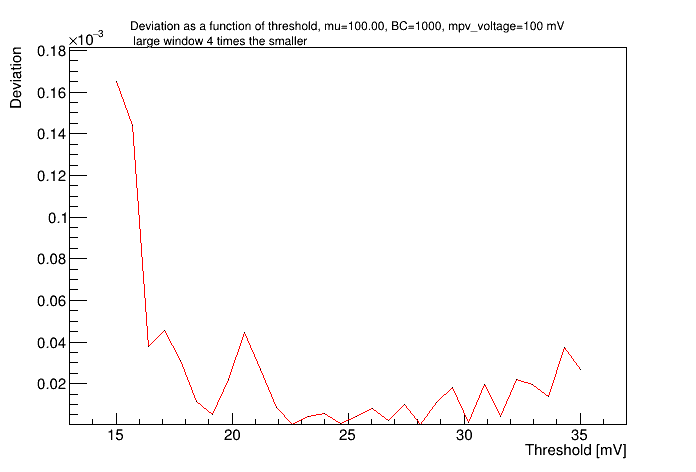

In [30]:
best = find_best_threshold(total_deviation)
print("Best threshold: %d"%best)

c1 = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%.2f, BC=%d, mpv_voltage=%d mV}{\n large window 4 times the smaller}"  %(mu, bunch_crossings, peak_mpv_voltage))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw(); 
c1.Draw()
c1.Modified()
c1.Update();
print("CPU time: %s seconds" % (time.time() - start_time))

### Finer search for the best threshold: exact value

Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean_std


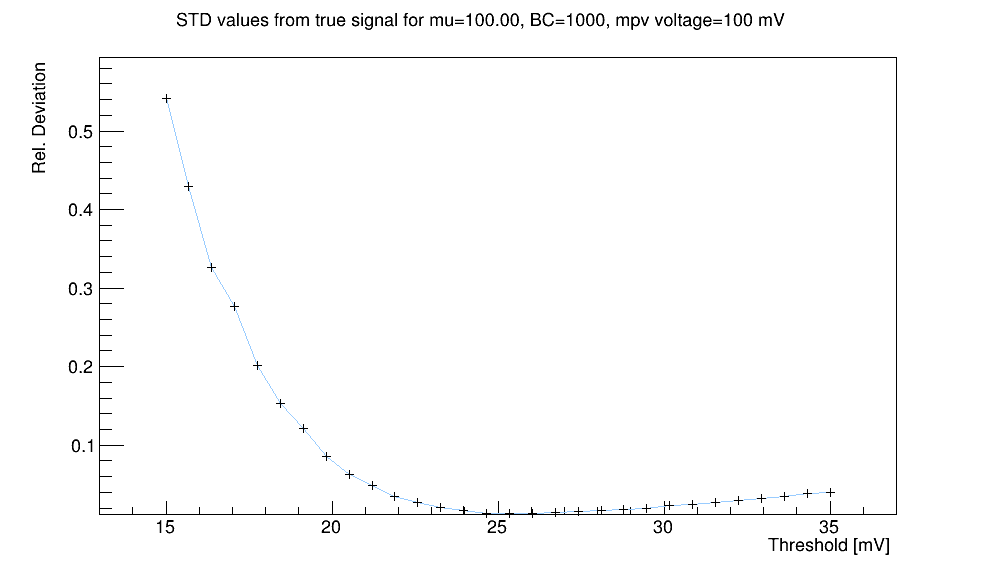

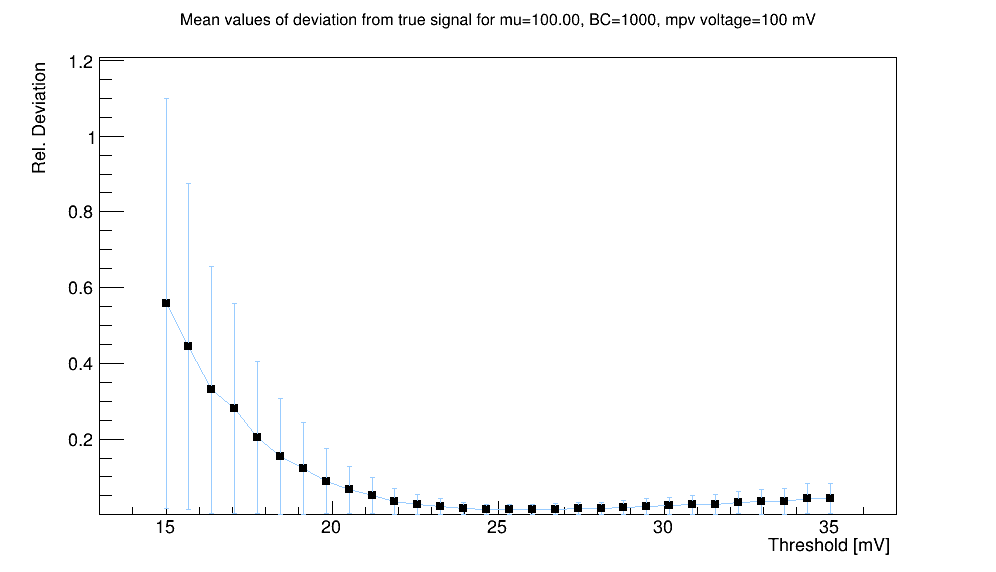

In [31]:
threshold_error = []
mean_rel = []
std_rel= []
mean_std_rel = []

#Calculate relative error for each array
for i in range (len(threshold_array)):
    threshold_error.append(0)
    #multiply by 100 to get relative error 
    std_rel.append(std_values[i]*100)
    mean_rel.append(mean_values[i]*100)
    mean_std_rel.append(mean_values_with_std[i]*100)

"""Standard deviation vs threshold plot"""

#create x,y values and corresponding errors

n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
y  = array( 'f', std_rel)
ey = array( 'f', threshold_error) 

std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c1 = ROOT.TCanvas("std over Threshold", "Difference in counts", 1000, 600)
#Set different plot settings 
std_graph.SetTitle("STD values from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
std_graph.SetMarkerStyle(2)
std_graph.SetLineColor(ROOT.kAzure-9)
std_graph.SetFillColor(ROOT.kAzure-14)
std_graph.Draw()

#Draw and export final Histo
#c1.SetLogy()
c1.Draw()

"""Mean value vs threshold plot"""

y  = array( 'f', mean_rel)
ey = array( 'f', std_rel) 

deviation_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c2 = ROOT.TCanvas("mean canvas", "", 1000, 600)
#Set different plot settings 
deviation_graph.SetTitle("Mean value of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
deviation_graph.SetMarkerStyle(21)
deviation_graph.SetLineColor(ROOT.kAzure-9)
deviation_graph.SetFillColor(ROOT.kAzure-14)
deviation_graph.Draw()

#Draw and export final Histo
#c2.Draw()

"""Mean+std vs threshold plot"""

y  = array( 'f', mean_std_rel)
ey = array( 'f', std_rel) 

mean_std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c3 = ROOT.TCanvas("mean_std", "Difference in counts", 1000, 600)
#Set different plot settings 
mean_std_graph.SetTitle("Mean values of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
mean_std_graph.SetMarkerStyle(21)
mean_std_graph.SetLineColor(ROOT.kAzure-9)
mean_std_graph.SetFillColor(ROOT.kAzure-14)
mean_std_graph.Draw()

#Draw and export final Histo
#c3.SetLogy()
c3.Draw()

### Study how the threshold and the deviation changes with worsening of the sensor with time because of radiation damage


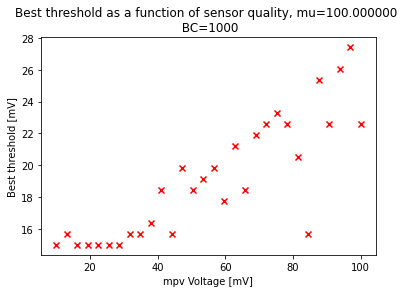

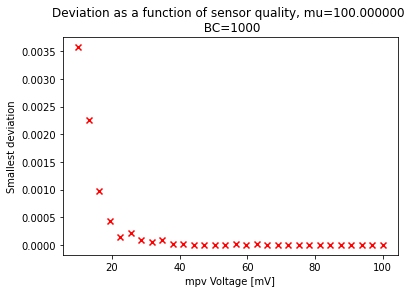

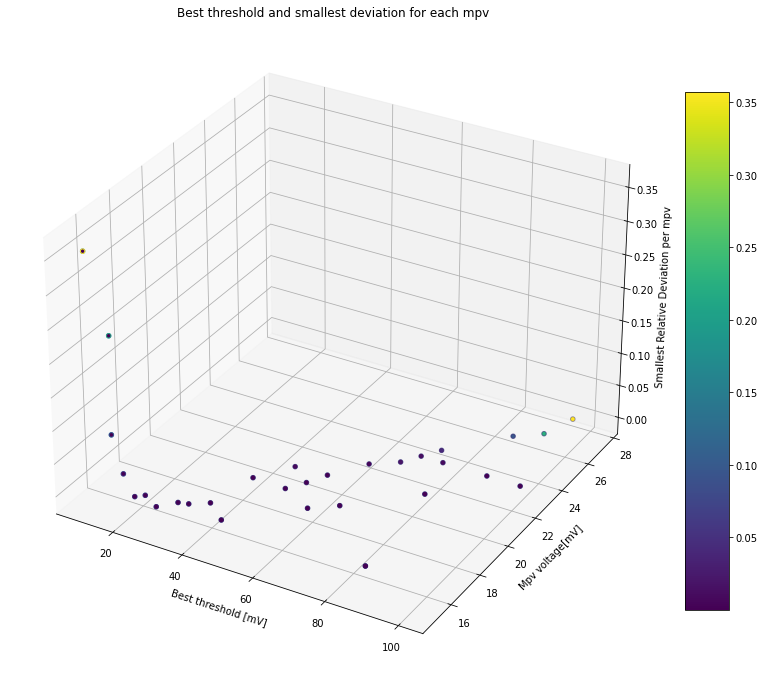

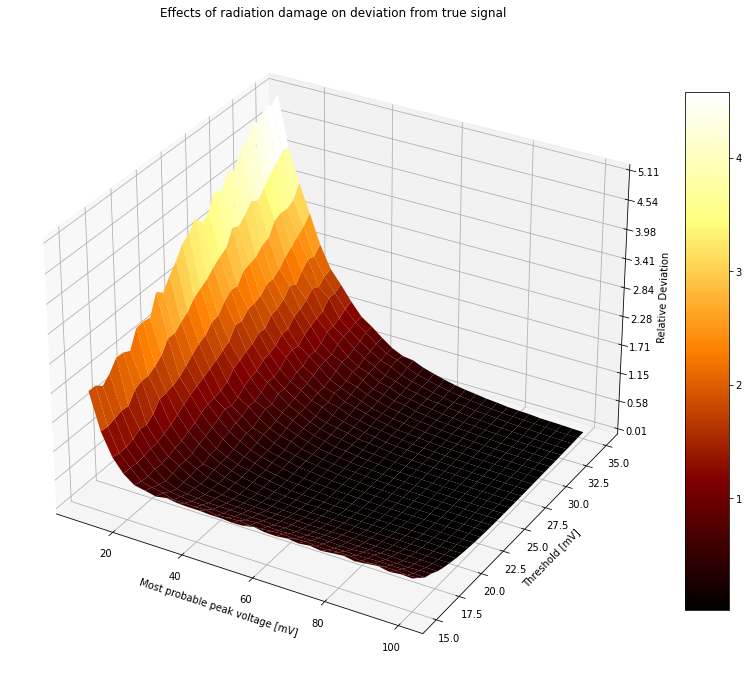

In [49]:
plt.scatter(mpv_peak_array, best_threshold_array, marker = "x", color='red')
plt.title("Best threshold as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Best threshold [mV]")
plt.show()

plt.scatter(mpv_peak_array, min_deviation_array, marker = "x", color='red')
plt.title("Deviation as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Smallest deviation")
plt.show()


"""3D scatter plot with best thresholds and minimal deviation for that threshold"""
x = mpv_peak_array
y = best_threshold_array
z = min_deviation_array*100
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y ,z)
pnt3d=ax.scatter(x,y,z,c=z)
ax.set_title('Best threshold and smallest deviation for each mpv')
ax.set_zlabel('Smallest Relative Deviation per mpv')
ax.set_xlabel('Best threshold [mV]')
ax.set_ylabel('Mpv voltage[mV]')
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.92, 0.2, 0.05, 0.6]) 
c = plt.colorbar(pnt3d, cax = cbaxes) 
plt.show()


"""3D plot of deviation as a function of mpv and threshold"""
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Relative Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.92, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()




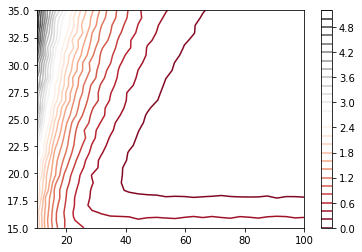

In [50]:
plt.contour(x, y, z, 30, cmap='RdGy');
plt.colorbar();

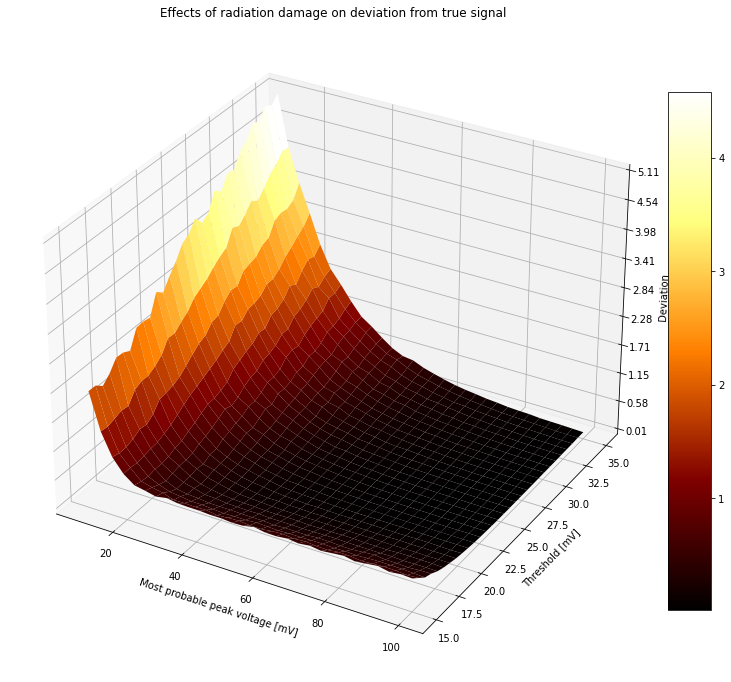

In [51]:
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.9, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()

snr = 20 in the beginning
snr = 5 later 

large time window multiple of 3.125

todo later: check non-linear approximation of nr of particles vs mu 

